In [43]:
#Parameters: Photometry table from Ned search, check that represents spatial mode and qualifiers based on w3 availability, and start index of wise photometry data in the photometry table
#Returns: WISE photometry values and their spatial mode and qualifiers
def SMCheck(WISETable, check, WISEPositions):
    import math
    import numpy as np
    WISEsliceT = WISETable[WISEPositions:WISEPositions+3]
    fit, fiterr, fitC, fluxAp8, fluxAp8err, fluxAp8C, fluxAp22, fluxAp22err, fluxAp22C = 0,'','',0,'','',0,'',''
    fitW3TempForSlice, fitW3, fitW3err, fitCW3 = 0, 0, 0, ''
    for i in range(len(WISEsliceT)):
        if check!=0 and np.ma.is_masked(WISEsliceT['Photometry Measurement'][i])==False:
            if WISEsliceT['Spatial Mode'][i]=='From fitting to map' and check==1: 
                fit = WISEsliceT['Photometry Measurement'][i]
                fiterr = WISEsliceT['Uncertainty'][i]
                fitC = 'From fitting to map, profile-fit'
            elif WISEsliceT['Spatial Mode'][i]=='Flux in fixed aperture' and WISEsliceT['Qualifiers'][i]=='r=8.25" COG-corrected' and check==2:  
                fluxAp8 = WISEsliceT['Photometry Measurement'][i]
                fluxAp8err = WISEsliceT['Uncertainty'][i]
                fluxAp8C = 'Flux in fixed aperture, r=8.25" COG-corrected'
            elif WISEsliceT['Spatial Mode'][i]=='Flux in fixed aperture' and WISEsliceT['Qualifiers'][i]=='r=22.0" aperture' and check==3:  
                fluxAp22 = WISEsliceT['Photometry Measurement'][i]
                fluxAp22err = WISEsliceT['Uncertainty'][i]
                fluxAp22C = 'Flux in fixed aperture, r=22.0 aperture'
        elif check==0 and np.ma.is_masked(WISEsliceT['Photometry Measurement'][i])==False:
            if WISEsliceT['Spatial Mode'][i]=='From fitting to map': 
                fit = WISEsliceT['Photometry Measurement'][i]
                fiterr = WISEsliceT['Uncertainty'][i]
                fitC = 'From fitting to map, profile-fit'
            elif WISEsliceT['Spatial Mode'][i]=='Flux in fixed aperture' and WISEsliceT['Qualifiers'][i]=='r=8.25" COG-corrected':  
                fluxAp8 = WISEsliceT['Photometry Measurement'][i]
                fluxAp8err = WISEsliceT['Uncertainty'][i]
                fluxAp8C = 'Flux in fixed aperture, r=8.25" COG-corrected'
            elif WISEsliceT['Spatial Mode'][i]=='Flux in fixed aperture' and WISEsliceT['Qualifiers'][i]=='r=22.0" aperture':  
                fluxAp22 = WISEsliceT['Photometry Measurement'][i]
                fluxAp22err = WISEsliceT['Uncertainty'][i]
                fluxAp22C = 'Flux in fixed aperture, r=22.0 aperture'
        elif check==0 and np.ma.is_masked(WISEsliceT['Photometry Measurement'][i])==True:
            if WISEsliceT['Spatial Mode'][i]=='From fitting to map':
                fitW3TempForSlice = WISEsliceT['Uncertainty'][i]
                fitW3 = fitW3TempForSlice[1:]
                fitW3err = 50
                fitCW3 = 'From fitting to map, profile-fit'
    
    if math.isnan(fit)==False and fit!=0:
        return fit, float(fiterr[3:]), fitC
    elif math.isnan(fluxAp8)==False and fluxAp8!=0:
        return fluxAp8, float(fluxAp8err[3:]), fitAp8C
    elif math.isnan(fluxAp22)==False and fluxAp22!=0:
        return fluxAp22, float(fluxAp22err[3:]), fluxAp22C
    elif check==0 and fitW3!=0: #if there is no W3 value
        return fitW3, fitW3err, fitCW3
    else:
        return 'No WISE photometry data available', 'None', 'Nada'

    
#Parameters: Ned search table. Checks if there is a WISE source within 10 arcsec of the observed object
#Returns the WISE name of the source if there is one
def WISESlice(table):
    i = 0
    mini = 1
    slicedWISEConfirm = ''
    for i in range(len(table)):
        nameCheck = table['Object Name'][i]
        wiseCheck = nameCheck[0:4]
        if table['Separation'][i]<=0.167 and table['Separation'][i]<mini and wiseCheck=='WISE':
            mini = table['Separation'][i]
            name = table['Object Name'][i]
            slicedWISEConfirm = wiseCheck
    
    if slicedWISEConfirm=='WISE' and mini<=0.167:
        return name
    else:   
        return 'No WISE'

    
#Parameters: Source ID from a selected run. Calculates coordinates of WISE source on a colour-colour plot.
#Returns: x, y coordinates, spatial mode and qualifiers, and colour of source that is going to be plotted based on w3 availability
def nedWISEsearch(ID):
    import math
    from astroquery.ipac.ned import Ned
    name = ''
    cSource = my_run.get_source(ID)
    nedCheck = cSource.ned_search()
    
    wiseConfirm= WISESlice(nedCheck)
    if wiseConfirm=='No WISE':
        return 0,0,0,0,0, print('No WISE photometry data available')
    else:
        name = wiseConfirm
        
    result_table = Ned.get_table(name, table='photometry')
    
    w1, w1err, w1Type, w2, w2err, w2Type, w3, w3err, w3Type = 0, 0, '', 0, 0, '', 0, 0, ''
    v1, v2, v3 = False, False, False
    wType = 0
    colourX = 'nothing'
    
    for i in range(len(result_table)):
        if result_table['Observed Passband'][i]=='W3 (WISE)' and v3==False:
            w3, w3err, w3Type = SMCheck(result_table, wType, i) 
            v3 = True
            if w3Type=='From fitting to map, profile-fit':
                wType = 1
                if w3err==50:
                    colourX = 'magenta'
                else:
                    colourX = 'black'
            elif w3Type=='Flux in fixed aperture, r=8.25" COG-corrected':
                wType = 2
                colourX = 'blue'
            elif w3Type=='Flux in fixed aperture, r=22.0 aperture':
                wType = 3
                colourX = 'red'
            elif w3Type=='Nada':
                return 0,0,0,0,0, print('No WISE photometry data available')
    for i in range(len(result_table)):
        if result_table['Observed Passband'][i]=='W2 (WISE)' and v2==False and v3==True:
            w2, w2err, w2Type = SMCheck(result_table, wType, i)
            v2 = True
            if w2Type=='Nada':
                return 0,0,0,0,0, print('No WISE photometry data available')
    for i in range(len(result_table)):
        if result_table['Observed Passband'][i]=='W1 (WISE)' and v1==False and v2==True and v3==True:
            w1, w1err, w1Type = SMCheck(result_table, wType, i)
            v1 = True
            if w1Type=='Nada':
                return 0,0,0,0,0, print('No WISE photometry data available')
    
    w3 = float(w3)
    y = w1-w2
    yerr = w1err-w2err
    x = w2-w3
    if w3err==50:
        xerr = 0.5
    else:
        xerr = w2err-w3err
    
    if colourX!='nothing':
        try:
            return x, y, xerr, yerr, w3Type, colourX
        except UnboundLocalError:
            print('No WISE photometry data available')
    else:
        return 0,0,0,0,0, print('No WISE photometry data available')

In [2]:
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
from vasttools.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

from xml.dom import minidom
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from svgpath2mpl import parse_path

pipe = Pipeline(project_dir="/data/vast-pipeline/vast-pipeline/pipeline-runs")
my_run = pipe.load_run('dwf_sep2021_final')

In [3]:
def calc_fig_size(width, height=None):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    if height is None:
        golden_ratio = (5**.5 - 1) / 2
        fig_height_pt = fig_width_pt * golden_ratio
    else:
        fig_height_pt = height

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_height_pt * inches_per_pt

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 8,
        "font.size": 8,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "lines.markersize": 4,
}

mpl.rcParams.update(nice_fonts)

In [4]:
doc = minidom.parse("WISE-color-color.svg")

In [5]:
patch_styles = {
    "CoolTDwarfs": {
        "style": dict(fc="#cb4627", ec="none"),
        "annotation": ("Cool\nT-Dwarfs", (1.15, 3.0)),
    },
    "Stars": {
        "style": dict(fc="#e8e615", ec="none"),
        "annotation": ("Stars", (0.5, 0.4)),
    },
    "Ellipticals": {
        "style": dict(fc="#95c53d", ec="none"),
        "annotation": ("Ellipticals", (1.0, -0.25)),
    },
    "Spirals": {
        "style": dict(fc="#bbdeb5", ec="none", alpha=0.7),
        "annotation": ("Spirals", (2.5, 0.35)),
    },
    "LIRGs": {
        "style": dict(fc="#ecc384", ec="none"),
        "annotation": ("LIRGs", (5.0, -0.1)),
    },
    "Starbursts": {
        "style": dict(fc="#e8e615", ec="none", alpha=0.7),
        "annotation": ("ULIRGs\nLINERs\nStarbursts", (4.75, 0.5)),
    },
    "Seyferts": {
        "style": dict(fc="#45c7f0", ec="none", alpha=0.7),
        "annotation": ("Seyferts", (3.5, 0.9)),
    },
    "QSOs": {
        "style": dict(fc="#b4e2ec", ec="none"),
        "annotation": ("QSOs", (3.1, 1.25)),
    },
    "ObscuredAGN": {
        "style": dict(fc="#faa719", ec="none", alpha=0.8),
        "annotation": ("ULIRGs/LINERs\nObscured AGN", (4.5, 1.75)),
    },
}

In [6]:
markers = ['o', 's', '*', '^', 'v', 'x']

In [44]:
fig = plt.figure(figsize=calc_fig_size(250,280))
ax = fig.add_subplot()

# (0, 0) in SVG coords is upper-left. Configure some transforms to set it to the lower-left.
rotate = mpl.transforms.Affine2D().rotate_deg(180)
flip = mpl.transforms.Affine2D().scale(sx=-1, sy=1)
translate = mpl.transforms.Affine2D().translate(0, 4.50)
translate += mpl.transforms.Affine2D().translate(-1, -0.5)

# plot classification regions
for svg_path in doc.getElementsByTagName("path"):
    name = svg_path.getAttribute("id")
    path_mpl = parse_path(svg_path.getAttribute("d")).transformed(rotate + flip + translate)
    patch = mpl.patches.PathPatch(path_mpl, **patch_styles[name]["style"])
    ax.add_patch(patch)
    ax.annotate(*patch_styles[name]["annotation"], ha="center")
    
ax.set_xlim(-1, 6)
ax.set_ylim(-0.5, 4)
#ax.set_aspect(1)
ax.set_xlabel("[4.6] - [12] (mag)")
ax.set_ylabel("[3.4] - [4.6] (mag)")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))


In [45]:
x, y, xError, yError, wSMQ, cl = nedWISEsearch(5791462)  #5792384 5828712 5791462 5837934 5803269 5795059 5823771

if wSMQ!=0:
    print(x,y, wSMQ, xError, yError)
    ax.plot(x, y, color=cl, marker='*', markersize=6)
    if cl!='magenta':
        ax.errorbar(x, y, yerr=yError, xerr=xError, ecolor=cl, elinewidth=1.0)
    else:
        ax.errorbar(x, y, yerr=yError, xerr=xError, ecolor=cl, elinewidth=1.0, xuplims=True)
    
    
    fig

    

2.555999999999999 0.3760000000000012 From fitting to map, profile-fit 0.5 -0.025


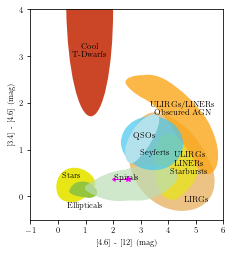

In [46]:
fig